In [9]:
import pandas as pd
import numpy as np
import pandas_ta as ta

In [10]:
df = pd.read_csv('./processed_data.csv')
df

,Date,Open,High,Low,Close,Adj Close,Volume,AO_5_34,APO_12_26,BIAS_SMA_26,...,STOCHk_14_3_3,STOCHd_14_3_3,STOCHRSIk_14_14_3_3,STOCHRSId_14_14_3_3,TRIX_30_9,TRIXs_30_9,TSI_13_25_13,TSIs_13_25_13,UO_7_14_28,WILLR_14
0,2016-07-21,1631.666626,1631.666626,1593.333374,1605.000000,1454.140381,25800,-1,-1,-1,...,-1,-1,-1,-1,1,1,-1,-1,-1,-1
1,2016-07-22,1608.333374,1628.333374,1603.333374,1603.333374,1452.630615,11700,-1,-1,-1,...,1,-1,0,-1,1,1,-1,-1,-1,-1
2,2016-07-25,1633.333374,1635.000000,1600.000000,1600.000000,1449.610474,22200,-1,-1,-1,...,-1,-1,-1,-1,1,1,-1,-1,-1,-1
3,2016-07-26,1631.666626,1665.000000,1616.666626,1663.333374,1506.990845,32700,1,-1,-1,...,1,1,1,1,1,1,1,-1,1,1
4,2016-07-27,1670.000000,1710.000000,1670.000000,1706.666626,1546.251099,30900,1,1,1,...,1,1,1,1,1,1,1,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1494,2022-08-03,12170.000000,12170.000000,11840.000000,12050.000000,12050.000000,96700,1,1,1,...,1,1,1,1,-1,-1,1,1,1,1
1495,2022-08-04,12250.000000,12640.000000,12100.000000,12540.000000,12540.000000,89200,1,1,1,...,1,1,1,1,-1,-1,1,1,1,1
1496,2022-08-05,12650.000000,12780.000000,12350.000000,12500.000000,12500.000000,86000,1,1,1,...,1,1,1,1,1,-1,1,1,-1,-1
1497,2022-08-08,12350.000000,12470.000000,12060.000000,12320.000000,12320.000000,122900,1,1,1,...,-1,-1,-1,-1,1,-1,1,1,1,-1


In [11]:
def makePairedFeatures(df):
    cols = df.columns
    for i in range(7, len(cols)):
        for j in range(i+1, len(cols)):
            df[cols[i]+"+"+cols[j]] = -(df[cols[i]] * df[cols[j]])
    cols = df.columns
    for i in range(7, len(cols)):
        df["-"+cols[i]] = -df[cols[i]]
    
    return df.copy()
# makePairedFeatures(df)

In [12]:
def splitData(arr):
    train_count = len(arr) - 500
    val_count = 450
    return arr[:train_count], arr[train_count:train_count+val_count], arr[train_count+val_count:]

In [13]:
# df, df_val, df_test = splitData(df)

In [14]:
def getBestColumns(df, horizon = 1):
    price = df["Adj Close"]
    perf = []
    for col in df.columns[7:]:
        acc = float('inf')
        for samp in [0.25, 0.5, 0.75, 1]:
            good = 0
            total = 0
            samp = round(samp * len(df)) + horizon
            start = max(len(df)-horizon-samp, 0)
            for i in range(start, len(df)-horizon):
                if df[col][i] == 1 and price[i] <= price[i+horizon]:
                    good +=1
                elif df[col][i] == -1 and price[i] >= price[i+horizon]:
                    good +=1
                total+=1
            acc = min(acc, good/total)
#         print(col, acc)
        perf.append((acc, col))

    perf = sorted(perf, reverse=True)
#     print(perf)
    best_cols = [colName for score, colName in perf]
    best_cols = best_cols[:min(25,len(best_cols))]
    return best_cols

# Filter out best columns based on training data
best_cols = getBestColumns(makePairedFeatures(df))
print(best_cols, len(best_cols))

C:\Users\anjur\AppData\Local\Temp\ipykernel_43636\1443834177.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[cols[i]+"+"+cols[j]] = -(df[cols[i]] * df[cols[j]])
C:\Users\anjur\AppData\Local\Temp\ipykernel_43636\1443834177.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[cols[i]+"+"+cols[j]] = -(df[cols[i]] * df[cols[j]])
C:\Users\anjur\AppData\Local\Temp\ipykernel_43636\1443834177.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

C:\Users\anjur\AppData\Local\Temp\ipykernel_43636\1443834177.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[cols[i]+"+"+cols[j]] = -(df[cols[i]] * df[cols[j]])
C:\Users\anjur\AppData\Local\Temp\ipykernel_43636\1443834177.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[cols[i]+"+"+cols[j]] = -(df[cols[i]] * df[cols[j]])
C:\Users\anjur\AppData\Local\Temp\ipykernel_43636\1443834177.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

C:\Users\anjur\AppData\Local\Temp\ipykernel_43636\1443834177.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[cols[i]+"+"+cols[j]] = -(df[cols[i]] * df[cols[j]])
C:\Users\anjur\AppData\Local\Temp\ipykernel_43636\1443834177.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[cols[i]+"+"+cols[j]] = -(df[cols[i]] * df[cols[j]])
C:\Users\anjur\AppData\Local\Temp\ipykernel_43636\1443834177.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

C:\Users\anjur\AppData\Local\Temp\ipykernel_43636\1443834177.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[cols[i]+"+"+cols[j]] = -(df[cols[i]] * df[cols[j]])
C:\Users\anjur\AppData\Local\Temp\ipykernel_43636\1443834177.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[cols[i]+"+"+cols[j]] = -(df[cols[i]] * df[cols[j]])
C:\Users\anjur\AppData\Local\Temp\ipykernel_43636\1443834177.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

C:\Users\anjur\AppData\Local\Temp\ipykernel_43636\1443834177.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[cols[i]+"+"+cols[j]] = -(df[cols[i]] * df[cols[j]])
C:\Users\anjur\AppData\Local\Temp\ipykernel_43636\1443834177.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[cols[i]+"+"+cols[j]] = -(df[cols[i]] * df[cols[j]])
C:\Users\anjur\AppData\Local\Temp\ipykernel_43636\1443834177.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

C:\Users\anjur\AppData\Local\Temp\ipykernel_43636\1443834177.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[cols[i]+"+"+cols[j]] = -(df[cols[i]] * df[cols[j]])
C:\Users\anjur\AppData\Local\Temp\ipykernel_43636\1443834177.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[cols[i]+"+"+cols[j]] = -(df[cols[i]] * df[cols[j]])
C:\Users\anjur\AppData\Local\Temp\ipykernel_43636\1443834177.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

C:\Users\anjur\AppData\Local\Temp\ipykernel_43636\1443834177.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[cols[i]+"+"+cols[j]] = -(df[cols[i]] * df[cols[j]])
C:\Users\anjur\AppData\Local\Temp\ipykernel_43636\1443834177.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[cols[i]+"+"+cols[j]] = -(df[cols[i]] * df[cols[j]])
C:\Users\anjur\AppData\Local\Temp\ipykernel_43636\1443834177.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

C:\Users\anjur\AppData\Local\Temp\ipykernel_43636\1443834177.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[cols[i]+"+"+cols[j]] = -(df[cols[i]] * df[cols[j]])
C:\Users\anjur\AppData\Local\Temp\ipykernel_43636\1443834177.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[cols[i]+"+"+cols[j]] = -(df[cols[i]] * df[cols[j]])
C:\Users\anjur\AppData\Local\Temp\ipykernel_43636\1443834177.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

C:\Users\anjur\AppData\Local\Temp\ipykernel_43636\1443834177.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df["-"+cols[i]] = -df[cols[i]]
C:\Users\anjur\AppData\Local\Temp\ipykernel_43636\1443834177.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df["-"+cols[i]] = -df[cols[i]]
C:\Users\anjur\AppData\Local\Temp\ipykernel_43636\1443834177.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at 

C:\Users\anjur\AppData\Local\Temp\ipykernel_43636\1443834177.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df["-"+cols[i]] = -df[cols[i]]
C:\Users\anjur\AppData\Local\Temp\ipykernel_43636\1443834177.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df["-"+cols[i]] = -df[cols[i]]
C:\Users\anjur\AppData\Local\Temp\ipykernel_43636\1443834177.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at 

C:\Users\anjur\AppData\Local\Temp\ipykernel_43636\1443834177.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df["-"+cols[i]] = -df[cols[i]]
C:\Users\anjur\AppData\Local\Temp\ipykernel_43636\1443834177.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df["-"+cols[i]] = -df[cols[i]]
C:\Users\anjur\AppData\Local\Temp\ipykernel_43636\1443834177.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at 

C:\Users\anjur\AppData\Local\Temp\ipykernel_43636\1443834177.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df["-"+cols[i]] = -df[cols[i]]
C:\Users\anjur\AppData\Local\Temp\ipykernel_43636\1443834177.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df["-"+cols[i]] = -df[cols[i]]
C:\Users\anjur\AppData\Local\Temp\ipykernel_43636\1443834177.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at 

C:\Users\anjur\AppData\Local\Temp\ipykernel_43636\1443834177.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df["-"+cols[i]] = -df[cols[i]]
C:\Users\anjur\AppData\Local\Temp\ipykernel_43636\1443834177.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df["-"+cols[i]] = -df[cols[i]]
C:\Users\anjur\AppData\Local\Temp\ipykernel_43636\1443834177.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at 

C:\Users\anjur\AppData\Local\Temp\ipykernel_43636\1443834177.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df["-"+cols[i]] = -df[cols[i]]
C:\Users\anjur\AppData\Local\Temp\ipykernel_43636\1443834177.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df["-"+cols[i]] = -df[cols[i]]
C:\Users\anjur\AppData\Local\Temp\ipykernel_43636\1443834177.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at 

C:\Users\anjur\AppData\Local\Temp\ipykernel_43636\1443834177.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df["-"+cols[i]] = -df[cols[i]]
C:\Users\anjur\AppData\Local\Temp\ipykernel_43636\1443834177.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df["-"+cols[i]] = -df[cols[i]]
C:\Users\anjur\AppData\Local\Temp\ipykernel_43636\1443834177.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at 

C:\Users\anjur\AppData\Local\Temp\ipykernel_43636\1443834177.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df["-"+cols[i]] = -df[cols[i]]
C:\Users\anjur\AppData\Local\Temp\ipykernel_43636\1443834177.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df["-"+cols[i]] = -df[cols[i]]
C:\Users\anjur\AppData\Local\Temp\ipykernel_43636\1443834177.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at 

C:\Users\anjur\AppData\Local\Temp\ipykernel_43636\1443834177.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df["-"+cols[i]] = -df[cols[i]]
C:\Users\anjur\AppData\Local\Temp\ipykernel_43636\1443834177.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df["-"+cols[i]] = -df[cols[i]]
C:\Users\anjur\AppData\Local\Temp\ipykernel_43636\1443834177.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at 

C:\Users\anjur\AppData\Local\Temp\ipykernel_43636\1443834177.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df["-"+cols[i]] = -df[cols[i]]
C:\Users\anjur\AppData\Local\Temp\ipykernel_43636\1443834177.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df["-"+cols[i]] = -df[cols[i]]
C:\Users\anjur\AppData\Local\Temp\ipykernel_43636\1443834177.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at 

C:\Users\anjur\AppData\Local\Temp\ipykernel_43636\1443834177.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df["-"+cols[i]] = -df[cols[i]]
C:\Users\anjur\AppData\Local\Temp\ipykernel_43636\1443834177.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df["-"+cols[i]] = -df[cols[i]]
C:\Users\anjur\AppData\Local\Temp\ipykernel_43636\1443834177.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at 

C:\Users\anjur\AppData\Local\Temp\ipykernel_43636\1443834177.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df["-"+cols[i]] = -df[cols[i]]
C:\Users\anjur\AppData\Local\Temp\ipykernel_43636\1443834177.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df["-"+cols[i]] = -df[cols[i]]
C:\Users\anjur\AppData\Local\Temp\ipykernel_43636\1443834177.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at 

['CFO_9+PPOs_12_26_9', 'CFO_9+PPOh_12_26_9', 'PPOs_12_26_9+QQE_14_5_4.236_RSIMA', 'PPOh_12_26_9+QQE_14_5_4.236_RSIMA', 'BR_26+SMIs_5_20_5', 'BEARP_13+KSTs_9', 'DMP_14+KSTs_9', 'KSTs_9+QQE_14_5_4.236_RSIMA', 'PPOs_12_26_9+ROC_10', 'PPOh_12_26_9+ROC_10', 'FISHERT_9_1+SQZPRO_ON_NARROW', 'BR_26+SMI_5_20_5', '-ER_10+PGO_14', 'PGO_14+SQZ_NO', 'PGO_14+SQZPRO_NO', 'PGO_14', 'CG_10+PGO_14', 'PPOs_12_26_9+TRIX_30_9', 'PPOh_12_26_9+TRIX_30_9', '-AO_5_34+AR_26', 'PPOs_12_26_9+TRIXs_30_9', 'PPOh_12_26_9+TRIXs_30_9', '-DMN_14+PPOs_12_26_9', '-DMN_14+PPOh_12_26_9', '-AO_5_34+MACDs_12_26_9'] 25


In [22]:
def colNamesToArr(colNames, df):
    return np.array([df[col].to_numpy() for col in colNames]).T

import itertools
def scoreCombinations(df, colNames, horizon = 1):
    print("Cols", len(colNames))
    arr, prices = colNamesToArr(colNames, df), df["Adj Close"].to_numpy()
    mask = np.zeros(len(colNames), dtype=np.int32)
    true = []

    for i in range(len(prices)-horizon):
        if prices[i] < prices[i+horizon]:
            true.append(1)
        else:
            true.append(-1)

    true = np.array(true)
#     print(arr.shape)
    slicedArr = arr[:len(true),:]
    bestScore = 0
    bestSubset = np.copy(mask)
    bestBySize = {}
#     print(true.shape)
    for size in [1, 3]:
        for combo in itertools.combinations(range(len(colNames)), size):
            mask = np.zeros(len(colNames))
            mask[list(combo)]=1
#             print(mask)
            prod = slicedArr @ mask
#             print(prod)
            prod = np.clip(prod, -1, 1)
            correct = np.sum(prod == true)
            score = correct / np.count_nonzero(prod)
#             print(score)
            if score > bestScore:
                print("Best so far", score, repr(mask))
                bestScore = score
                bestSubset = mask
#             print(mask)
#             print(combo)
#         for i in range(2 ** len(colNames)):
#             addOne(mask)   
#             if np.sum(mask) % 2 == 0:
#                 continue

                
    return bestScore, bestSubset

# _, bestMask = scoreCombinations(df, getBestColumns(df))

In [23]:
def testCombo(mask, df, colNames, horizon = 1):
    arr, prices = colNamesToArr(colNames, df), df["Adj Close"].to_numpy()
    pred = arr @ mask
    pred = np.clip(pred, -1, 1)[:-1]
    true = []
    for i in range(len(prices)-1):
        if prices[i] < prices[i+horizon]:
            true.append(1)
        else:
            true.append(-1)
 
    true = np.array(true)
#     print(np.unique(true, return_counts=True))
    correct = np.sum(pred == true)
    score = correct / np.count_nonzero(pred)
        
    return score

In [87]:
# print(getBestColumns(df))

testCombo(bestMask[1], df ,getBestColumns(df))

NameError: name 'bestMask' is not defined

In [16]:
df_test.plot(x="Date", y="Adj Close")

NameError: name 'df_test' is not defined

In [24]:
def plotPerformance(df_test, best_cols, test_mask, title):
    price = df_test["Adj Close"].to_numpy()
    test_arr = colNamesToArr(best_cols, df_test)

    sim_price = [price[0]]
    pred = test_arr @ test_mask
    pred = np.clip(pred, -1, 1)

    print(pred)

    areIn = False
    unitsHeld = 0
    cash = price[0]
    if pred[0] == 1:
        areIn = True
        unitsHeld = 1
        cash = 0
    trades = 0
    for i in range(1, len(pred)):
        if areIn and pred[i] == -1:
            # Sell
            areIn = False
            cash = unitsHeld * price[i]
            unitsHeld = 0
            trades+=1
        elif not areIn and pred[i] == 1:
            # Buy
            areIn = True
            unitsHeld = cash/price[i]
            cash = 0
            trades+=1
        sim_price.append(unitsHeld * price[i] + cash)
    
    print("Trades Made", trades)

    df_test["Simulated Price"] = sim_price
    return df_test.plot(x="Date", y=["Adj Close", "Simulated Price"], title=title)

In [25]:
plotPerformance(df_test)

NameError: name 'df_test' is not defined

In [71]:
plotPerformance(pd.concat([df_val, df_test], axis=0))

NameError: name 'df_val' is not defined

In [72]:
plotPerformance(pd.concat([df, df_val, df_test], axis=0))

NameError: name 'df_val' is not defined

In [26]:
def runAnalysis(df, title):
    df, df_val, df_test = splitData(makePairedFeatures(df))
    print("Train, Val, Test split")
    print(len(df), len(df_val), len(df_test))
    df_val.reset_index(drop=True, inplace=True)
    best_cols = getBestColumns(df)
    _, test_mask = scoreCombinations(df_val, best_cols)
    print("Done")
    using = []
    for mask, colName in zip(test_mask, best_cols):
        if mask == 1:
            using.append(colName)
    print("Combining momentum predictions from", using)
    print("Test Accuracy:", testCombo(test_mask, df_test, best_cols))
    plotPerformance(df_test, best_cols, test_mask, title)
#     plotPerformance(pd.concat([df_val, df_test], axis=0), best_cols, test_mask, title)
#     plotPerformance(pd.concat([df, df_val, df_test], axis=0), best_cols, test_mask, title)

In [27]:
def normalize_col(arr, col):
    mx, mn = np.max(arr), np.min(arr)
    norm = [-21]
    if mx - mn > 20:
#         print(col, "norm diff", arr[:5])
        for i in range(1, len(arr)):
            if arr[i]>arr[i-1]:
                norm.append(1)
            elif arr[i]<arr[i-1]:
                norm.append(-1)
            else:
                norm.append(0)
    elif mn >=0:
#         print(col, "norm 0 -> 1 snap", arr[:5])
        for i in range(1, len(arr)):
            if arr[i] > 0:
                norm.append(1)
            else:
                norm.append(-1)
    else:
#         print(col, "norm -1 -> 1 snap", arr[:5])
        for i in range(1, len(arr)):
            if arr[i] > 0:
                norm.append(1)
            elif arr[i] < 0:
                norm.append(-1)
            else:
                norm.append(0)
    return np.array(norm)

In [28]:
def proccessData(df):
    df.dropna(inplace=True, how='any')
    df.reset_index(drop=True, inplace=True)
    indicators="""ao
    apo
    bias
    bop
    brar
    cci
    cfo
    cg
    cmo
    coppock
    cti
    dm
    er
    eri
    fisher
    inertia
    kdj
    kst
    macd
    mom
    pgo
    ppo
    psl
    pvo
    qqe
    roc
    rsi
    rsx
    rvgi
    stc
    slope
    smi
    squeeze
    squeeze_pro
    stoch
    stochrsi
    trix
    tsi
    uo
    willr"""
    CustomStrategy = ta.Strategy(
        name="Momentums",
        description="Bunch of different momentum measurements",
        ta=[
            {"kind": ind} for ind in indicators.split()
        ]
    )
    df.ta.strategy(CustomStrategy)
    
    if len(df) > 1500:
        df= df[-1500:]
    else:
        df = df[50:]
    
    df.dropna(axis=1, inplace=True, how='any')
    df["Date"] = pd.to_datetime(df["Date"])
    
    columns = df.columns
    for col in columns[7:]:
        df[col] = normalize_col(df[col].to_numpy(), col)
    df = df[1:]
    df.reset_index(drop=True, inplace=True)

    return df

C:\Users\anjur\AppData\Local\Temp\ipykernel_43636\3067418901.py:58: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.dropna(axis=1, inplace=True, how='any')
C:\Users\anjur\AppData\Local\Temp\ipykernel_43636\3067418901.py:59: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Date"] = pd.to_datetime(df["Date"])
C:\Users\anjur\AppData\Local\Temp\ipykernel_43636\3067418901.py:63: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: htt

Train, Val, Test split
999 450 50
Cols 25
Best so far 0.48997772828507796 array([1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0.])
Best so far 0.5167037861915368 array([0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0.])
Best so far 0.5189309576837416 array([0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0.])
Best so far 0.534521158129176 array([0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0.])
Best so far 0.5434298440979956 array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0.])
Best so far 0.5501113585746102 array([0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
       0., 0., 0., 0., 0., 0., 0., 0.])
Best so far 0.5545657015590201 array([0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 

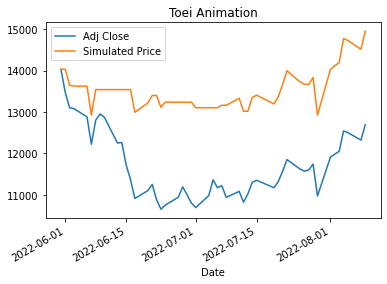

In [29]:
df = pd.read_csv('./4816.T.csv')
processed = proccessData(df)
runAnalysis(processed, "Toei Animation")

C:\Users\anjur\AppData\Local\Temp\ipykernel_43636\3067418901.py:58: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.dropna(axis=1, inplace=True, how='any')
C:\Users\anjur\AppData\Local\Temp\ipykernel_43636\3067418901.py:59: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Date"] = pd.to_datetime(df["Date"])
C:\Users\anjur\AppData\Local\Temp\ipykernel_43636\3067418901.py:63: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: htt

Train, Val, Test split
688 450 50
Cols 25
Best so far 0.49665924276169265 array([1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0.])
Best so far 0.502262443438914 array([0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0.])
Best so far 0.5501113585746102 array([0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0.])
Best so far 0.5523385300668151 array([1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0.])
Best so far 0.5590200445434298 array([1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0.])
Best so far 0.576837416481069 array([0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
       0., 1., 0., 0., 0., 0., 0., 0.])
Done
Combining momentum predictions from ['-BULLP_13+UO_7_14_28', 'FISHERTs_9_1+SMI

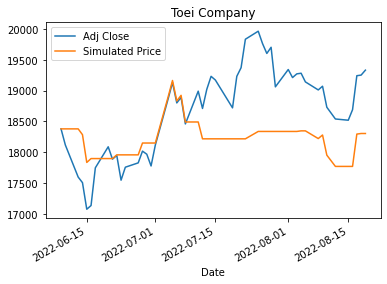

In [30]:
df = pd.read_csv('./9605.T.csv')
processed = proccessData(df)
runAnalysis(processed, "Toei Company")

C:\Users\anjur\AppData\Local\Temp\ipykernel_43636\3067418901.py:58: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.dropna(axis=1, inplace=True, how='any')
C:\Users\anjur\AppData\Local\Temp\ipykernel_43636\3067418901.py:59: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Date"] = pd.to_datetime(df["Date"])
C:\Users\anjur\AppData\Local\Temp\ipykernel_43636\3067418901.py:63: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: htt

Train, Val, Test split
999 450 50
Cols 25
Best so far 0.49665924276169265 array([1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0.])
Best so far 0.5033557046979866 array([0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0.])
Best so far 0.5300668151447662 array([0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0.])
Best so far 0.532293986636971 array([0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0.])
Best so far 0.5434298440979956 array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 1., 0.])
Best so far 0.5458612975391499 array([0., 0., 1., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0.])
Best so far 0.5525727069351231 array([0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 

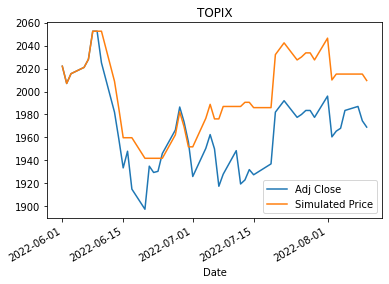

In [31]:
df = pd.read_csv('./1308.T.csv')
processed = proccessData(df)
runAnalysis(processed, 'TOPIX')

C:\Users\anjur\AppData\Local\Temp\ipykernel_43636\3067418901.py:58: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.dropna(axis=1, inplace=True, how='any')
C:\Users\anjur\AppData\Local\Temp\ipykernel_43636\3067418901.py:59: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Date"] = pd.to_datetime(df["Date"])
C:\Users\anjur\AppData\Local\Temp\ipykernel_43636\3067418901.py:63: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: htt

Train, Val, Test split
999 450 50
Cols 25
Best so far 0.5456570155902004 array([1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0.])
Best so far 0.5567928730512249 array([0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0.])
Best so far 0.5612472160356348 array([1., 0., 0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0.])
Best so far 0.5701559020044543 array([1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 1., 0.])
Best so far 0.5723830734966593 array([0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 1., 0.])
Best so far 0.576837416481069 array([0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 1., 0.])
Done
Combining momentum predictions from ['BR_26+RVGIs_14_4', '-AO_5_34+J_9_3', '-K

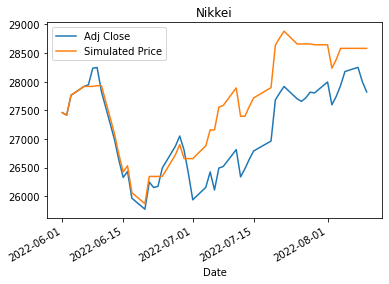

In [32]:
df = pd.read_csv('./^N225.csv')
processed = proccessData(df)
runAnalysis(processed, 'Nikkei')

C:\Users\anjur\AppData\Local\Temp\ipykernel_43636\3067418901.py:58: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.dropna(axis=1, inplace=True, how='any')
C:\Users\anjur\AppData\Local\Temp\ipykernel_43636\3067418901.py:59: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Date"] = pd.to_datetime(df["Date"])
C:\Users\anjur\AppData\Local\Temp\ipykernel_43636\3067418901.py:63: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: htt

Train, Val, Test split
707 450 50
Cols 25
Best so far 0.5278396436525612 array([1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0.])
Best so far 0.532293986636971 array([1., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0.])
Best so far 0.5412026726057907 array([1., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0.])
Best so far 0.5456570155902004 array([1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 1.])
Best so far 0.5590200445434298 array([1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 1., 0., 1.])
Done
Combining momentum predictions from ['-COPC_11_14_10+MACDh_12_26_9', '-MACDs_12_26_9+SMIs_5_20_5', '-FISHERT_9_1+TSI_13_25_13']
Test Accuracy: 0.4489795918367347
[ 1.  1. -1. -1.  1.  1.  1.  1.  1.  1.  1. -1.  1.  1.  1.  

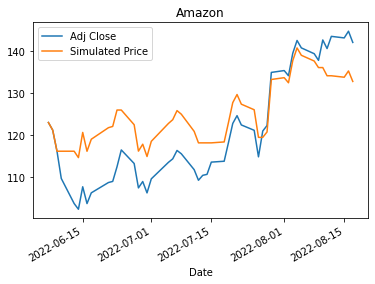

In [33]:
df = pd.read_csv('./AMZN.csv')
processed = proccessData(df)
runAnalysis(processed, 'Amazon')

C:\Users\anjur\AppData\Local\Temp\ipykernel_43636\3067418901.py:58: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.dropna(axis=1, inplace=True, how='any')
C:\Users\anjur\AppData\Local\Temp\ipykernel_43636\3067418901.py:59: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Date"] = pd.to_datetime(df["Date"])
C:\Users\anjur\AppData\Local\Temp\ipykernel_43636\3067418901.py:63: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: htt

Train, Val, Test split
707 450 50
Cols 25
Best so far 0.5011135857461024 array([1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0.])
Best so far 0.5367483296213809 array([0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0.])
Best so far 0.5501113585746102 array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.,
       0., 0., 0., 0., 0., 0., 0., 0.])
Done
Combining momentum predictions from ['-SMIo_5_20_5+TSI_13_25_13']
Test Accuracy: 0.5510204081632653
[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1.]
Trades Made 0


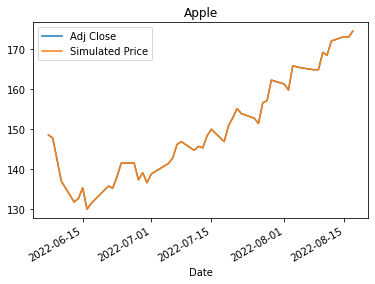

In [34]:
df = pd.read_csv('./AAPL.csv')
processed = proccessData(df)
runAnalysis(processed, 'Apple')

C:\Users\anjur\AppData\Local\Temp\ipykernel_43636\3067418901.py:58: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.dropna(axis=1, inplace=True, how='any')
C:\Users\anjur\AppData\Local\Temp\ipykernel_43636\3067418901.py:59: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Date"] = pd.to_datetime(df["Date"])
C:\Users\anjur\AppData\Local\Temp\ipykernel_43636\3067418901.py:63: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: htt

Train, Val, Test split
707 450 50
Cols 25
Best so far 0.5167037861915368 array([1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0.])
Best so far 0.5545657015590201 array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 1., 0., 0.])
Done
Combining momentum predictions from ['-SMIo_5_20_5+TSI_13_25_13']
Test Accuracy: 0.5102040816326531
[ 1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1. -1.  1.  1.
 -1.  1.  1.  1.  1. -1.  1.  1.  1.  1. -1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.]
Trades Made 8


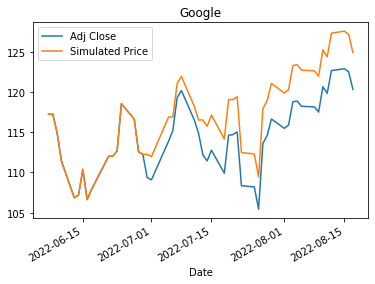

In [35]:
df = pd.read_csv('./GOOG.csv')
processed = proccessData(df)
runAnalysis(processed, 'Google')

C:\Users\anjur\AppData\Local\Temp\ipykernel_43636\3067418901.py:58: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.dropna(axis=1, inplace=True, how='any')
C:\Users\anjur\AppData\Local\Temp\ipykernel_43636\3067418901.py:59: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Date"] = pd.to_datetime(df["Date"])
C:\Users\anjur\AppData\Local\Temp\ipykernel_43636\3067418901.py:63: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: htt

Train, Val, Test split
707 450 50
Cols 25
Best so far 0.5634743875278396 array([1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0.])
Best so far 0.576837416481069 array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 1., 0., 0., 0., 0.])
Best so far 0.579064587973274 array([1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 1., 0., 0., 0., 0.])
Best so far 0.5835189309576837 array([1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
       0., 0., 0., 1., 0., 0., 0., 0.])
Done
Combining momentum predictions from ['-PVOs_12_26_9+RSX_14', '-J_9_3+PPOs_12_26_9', '-PVOs_12_26_9+SQZ_20_2.0_20_1.5']
Test Accuracy: 0.6122448979591837
[ 1.  1. -1. -1. -1. -1. -1. -1. -1. -1. -1.  1.  1.  1.  1. -1.  1. -1.
 -1. -1. -1. -1.  1.  1. -1. -1.  1.  1.  1.  1.  1.  1.  1.  1. -1. -1.
 -1. -1. -1.  1.  1.  1.  1.  1. -1.  1. -1. -1. -1.  1.]
Trades Made 14

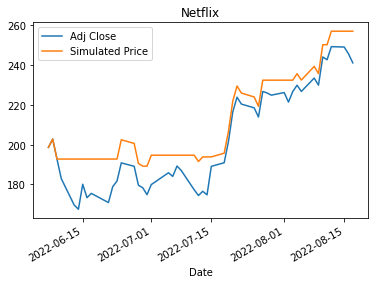

In [36]:
df = pd.read_csv('./NFLX.csv')
processed = proccessData(df)
runAnalysis(processed, 'Netflix')

C:\Users\anjur\AppData\Local\Temp\ipykernel_43636\3067418901.py:58: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.dropna(axis=1, inplace=True, how='any')
C:\Users\anjur\AppData\Local\Temp\ipykernel_43636\3067418901.py:59: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Date"] = pd.to_datetime(df["Date"])
C:\Users\anjur\AppData\Local\Temp\ipykernel_43636\3067418901.py:63: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: htt

Train, Val, Test split
707 450 50
Cols 25
Best so far 0.49443207126948774 array([1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0.])
Best so far 0.512249443207127 array([0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0.])
Best so far 0.5478841870824054 array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0.])
Best so far 0.5501113585746102 array([1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0.])
Best so far 0.5590200445434298 array([0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1.,
       0., 0., 0., 0., 0., 0., 0., 0.])
Best so far 0.5723830734966593 array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 1.,
       0., 0., 0., 0., 0., 0., 0., 0.])
Best so far 0.5746102449888641 array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 

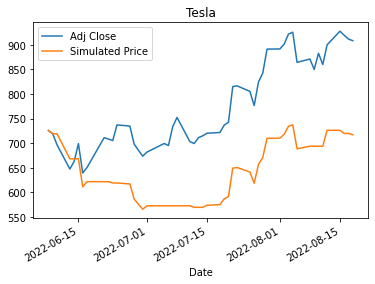

In [37]:
df = pd.read_csv('./TSLA.csv')
processed = proccessData(df)
runAnalysis(processed, 'Tesla')